<a href="https://colab.research.google.com/github/AliEbadi110/Computer-Vision-Image-Classification-Sample-Projects/blob/main/Computer_Vision_PyTorch_Image_Classification_CNN_Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Computer Vision - PyTorch - Image Classification - CNN - Cats vs Dogs**

## 1. Import Libraries

In [ ]:
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid
from torchsummary import summary

from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 2. Loading Data

In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp '/content/drive/MyDrive/Colab Datasets/kaggle.json' ~/.kaggle

In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog

 89% 193M/218M [00:01<00:00, 145MB/s]
100% 218M/218M [00:01<00:00, 140MB/s]


In [ ]:
!unzip cat-and-dog.zip

In [ ]:
!mkdir '/content/CatsDogs'
!mv '/content/training_set/training_set' '/content/CatsDogs'
!mv '/content/test_set/test_set' '/content/CatsDogs'

In [ ]:
path = '/content/CatsDogs'
img_names = []

for folder, subfolders, filenames in os.walk(path):
  for img in filenames:
    img_names.append(folder+'/'+img)

In [ ]:
len(img_names)

10032

In [ ]:
img_sizes = []
rejected = []

for item in img_names:
  try:
    with Image.open(item) as img:
      img_sizes.append(img.size)
  except:
    rejected.append(item)

In [ ]:
print(len(img_sizes))
print(len(rejected))

10028
4


In [ ]:
for i in rejected:
  os.remove(i)

In [ ]:
transformer_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    ])

In [ ]:
transformer_test = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    ])

In [ ]:
train_dataset = datasets.ImageFolder(
    root='/content/CatsDogs/training_set',
    transform=transformer_train)

In [ ]:
test_dataset = datasets.ImageFolder(
    root='/content/CatsDogs/test_set',
    transform=transformer_test)

In [ ]:
class_names = train_dataset.classes
class_names

['cats', 'dogs']

In [ ]:
batch_size = 16

train_loader = DataLoader(dataset=train_dataset,
                          batch_size=batch_size,
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=False)

## 3. Data Overview

In [ ]:
df = pd.DataFrame(img_sizes, columns=['width', 'height'])
df.head()

,width,height
0,119,90
1,120,89
2,433,477
3,489,499
4,500,374


In [ ]:
df.describe()

,width,height
count,10028.000000,10028.000000
mean,403.997108,360.507379
std,108.753655,96.945867
min,57.000000,33.000000
25%,322.000000,300.000000
50%,446.500000,374.000000
75%,499.000000,422.000000
max,1050.000000,768.000000


In [ ]:
print(f'Number of samples in training dataset: {len(train_dataset)}')
print(f"Number of cats in training dataset: {len(os.listdir('/content/CatsDogs/training_set/cats'))}")
print(f"Number of dogs in training dataset: {len(os.listdir('/content/CatsDogs/training_set/dogs'))}")

Number of samples in training dataset: 8005
Number of cats in training dataset: 4000
Number of dogs in training dataset: 4005


In [ ]:
print(f'Number of samples in test dataset: {len(test_dataset)}')
print(f"Number of cats in test dataset: {len(os.listdir('/content/CatsDogs/test_set/cats'))}")
print(f"Number of dogs in test dataset: {len(os.listdir('/content/CatsDogs/test_set/dogs'))}")

Number of samples in test dataset: 2023
Number of cats in test dataset: 1011
Number of dogs in test dataset: 1012


In [ ]:
for images, labels in train_loader:
  break

In [ ]:
images.shape

torch.Size([16, 3, 224, 224])

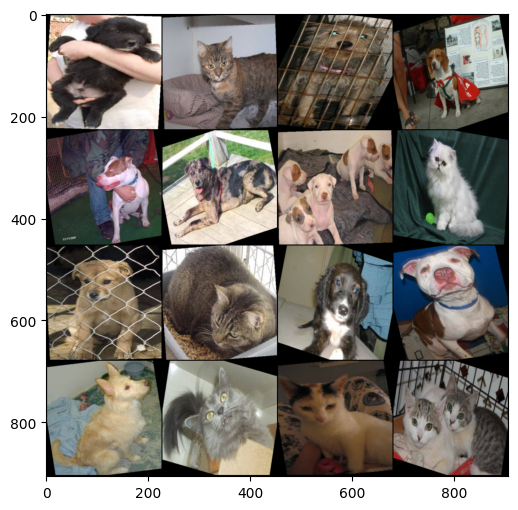

In [ ]:
im = make_grid(images, nrow=4)
plt.figure(figsize=(12, 6))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

## 4. Build Model

In [ ]:
# h_out = ((h_in+(2*padding[0])-(dilation[0]*(kernel_size[0]-1))-1)/stride[0])+1
print(np.floor((224+(2*0)-(1*(3-1))-1)/1)+1)
print(np.floor((111+(2*0)-(1*(3-1))-1)/1)+1)

222.0
109.0


In [ ]:
class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv_layers = nn.Sequential(
      nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3),
      nn.ReLU(),
      nn.MaxPool2d(2),
      nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3),
      nn.ReLU(),
      nn.MaxPool2d(2))
    self.dense_layers = nn.Sequential(
      nn.Flatten(),
      nn.Linear(54*54*16, 120),
      nn.ReLU(),
      nn.Linear(120, 84),
      nn.ReLU(),
      nn.Linear(84, 2),
      nn.LogSoftmax(dim=1))

  def forward(self, x):
    x = self.conv_layers(x)
    y_pred = self.dense_layers(x)
    return y_pred

In [ ]:
model = Model()
model.to(device)

Model(
  (conv_layers): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=46656, out_features=120, bias=True)
    (2): ReLU()
    (3): Linear(in_features=120, out_features=84, bias=True)
    (4): ReLU()
    (5): Linear(in_features=84, out_features=2, bias=True)
    (6): LogSoftmax(dim=1)
  )
)

In [ ]:
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 6, 222, 222]             168
              ReLU-2          [-1, 6, 222, 222]               0
         MaxPool2d-3          [-1, 6, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]             880
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
           Flatten-7                [-1, 46656]               0
            Linear-8                  [-1, 120]       5,598,840
              ReLU-9                  [-1, 120]               0
           Linear-10                   [-1, 84]          10,164
             ReLU-11                   [-1, 84]               0
           Linear-12                    [-1, 2]             170
       LogSoftmax-13                    [-1, 2]               0
Total params: 5,610,222
Trainable param

In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

## 5. Train Model

In [ ]:
n_epochs = 10
train_losses = np.zeros(n_epochs)
test_losses = np.zeros(n_epochs)

for i in range(n_epochs):

  model.train()
  train_loss = []
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs_train = model(inputs)
    loss_train = criterion(outputs_train, targets)

    loss_train.backward()
    optimizer.step()

    train_loss.append(loss_train.item())

  train_loss = np.mean(train_loss)


  model.eval()
  test_loss = []
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs_train = model(inputs)
    loss_test = criterion(outputs_train, targets)

    test_loss.append(loss_test.item())

  test_loss = np.mean(test_loss)

  train_losses[i] = train_loss
  test_losses[i] = test_loss

  print(f'Epoch {i+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch 1/10, Train Loss: 0.6873, Test Loss: 0.6516
Epoch 2/10, Train Loss: 0.6297, Test Loss: 0.6100
Epoch 3/10, Train Loss: 0.5874, Test Loss: 0.6123
Epoch 4/10, Train Loss: 0.5602, Test Loss: 0.5999
Epoch 5/10, Train Loss: 0.5398, Test Loss: 0.5508
Epoch 6/10, Train Loss: 0.5048, Test Loss: 0.5428
Epoch 7/10, Train Loss: 0.4878, Test Loss: 0.5091
Epoch 8/10, Train Loss: 0.4695, Test Loss: 0.5056
Epoch 9/10, Train Loss: 0.4523, Test Loss: 0.5133
Epoch 10/10, Train Loss: 0.4314, Test Loss: 0.5081


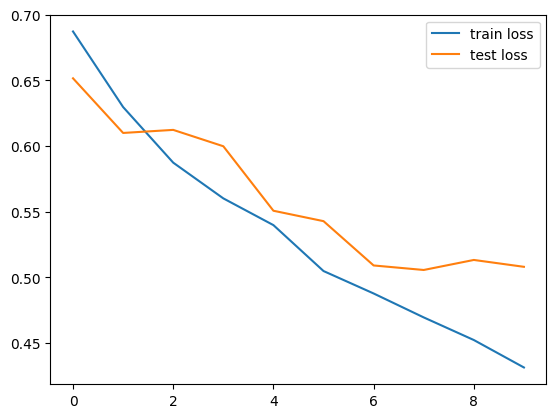

In [ ]:
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()

## 6. Predict, Evaluate

> **Classification**

In [ ]:
model.eval()
p_test = np.array([])
for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    p_test = np.concatenate((p_test, predictions.cpu().numpy()))

In [ ]:
y_test = np.array(test_dataset.targets)

In [ ]:
print(classification_report(p_test, y_test))

              precision    recall  f1-score   support

         0.0       0.72      0.79      0.75       916
         1.0       0.81      0.74      0.77      1107

    accuracy                           0.76      2023
   macro avg       0.76      0.76      0.76      2023
weighted avg       0.77      0.76      0.76      2023



In [ ]:
print(confusion_matrix(p_test, y_test))

[[723 193]
 [288 819]]


In [ ]:
labels = '''cats
dogs
'''.split('\n')

Text(0.5, 1.0, 'True label: cats   Predicted: dogs')

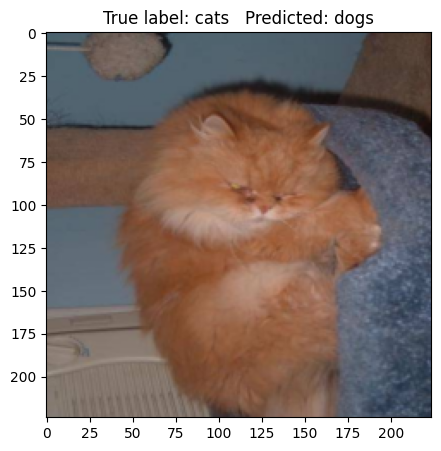

In [ ]:
p_test = p_test.astype(np.uint8)
misclassified_idx = np.where(p_test != y_test)[0]
i = np.random.choice(misclassified_idx)
fig = plt.figure(figsize=(5, 5))
plt.imshow(np.transpose(test_dataset[i][0]))
plt.title(f'True label: {labels[y_test[i]]}   Predicted: {labels[p_test[i]]}')